First, we fix the n_features = 2
And we fix hidden_dim = 1, with top-k = 1
We vary the number of experts from 2 -> N (N=8 for now)

How does feature space get divided amongst experts, as experts increase?
Does feature sparsity affect the specialization?
Does feature importance affect the specialization?

In [ ]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from model.model import Config, MoEModel, optimize, optimize_vectorized
from helpers.helpers import classify_expert_weights_2d

In [45]:
def other_optimize(model, 
             render=False, 
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             stop_loss=0.015,
             drop_loss=0.02,
             hooks=[]):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  # Replace trange with regular range
  for step in range(steps):
    step_lr = lr * lr_scale(step, steps)
    for group in opt.param_groups:
      group['lr'] = step_lr
    opt.zero_grad(set_to_none=True)
    batch = model.generate_batch(n_batch)
    out, load_balance_loss = model(batch)
    error = (model.importance*(batch.abs() - out)**2)
    reconstruction_loss = einops.reduce(error, 'b f -> f', 'mean').sum()
    
    loss = reconstruction_loss
    if load_balance_loss is not None:
      loss = loss + load_balance_loss
    
    loss.backward()
    opt.step()
  
    if hooks:
      hook_data = dict(model=model,
                       step=step, 
                       opt=opt,
                       error=error,
                       loss=loss,
                       reconstruction_loss=reconstruction_loss,
                       load_balance_loss=load_balance_loss,
                       lr=step_lr)
      for h in hooks:
        h(hook_data)
    if step % print_freq == 0 or (step + 1 == steps):
      print(f"Step {step}: loss={loss.item():.6f}, lr={step_lr:.6f}")
    

    if loss.item() < drop_loss:
      print(f"Dropping at step {step} with loss {loss.item():.6f}")
      lr = lr * 0.1
    if loss.item() < stop_loss:
      print(f"Stopping at step {step} with loss {loss.item():.6f}")
      break

In [ ]:
## ITERATE OVER NUMBER OF EXPERTS FOR 2 HIDDEN DIM
models_dict = {}
for num_expert in range(2, 9):
    config = Config(
        n_features=2,
        n_hidden=1,
        n_experts=num_expert,
        n_active_experts=1,
        load_balancing_loss=False,
    )

    model = MoEModel(config, device='cpu', feature_probability=torch.tensor(1), importance=torch.tensor(1))
    other_optimize(model, n_batch=100, steps=10000, print_freq=2000, stop_loss=0.015, drop_loss=0.02)
    models_dict[num_expert] = model



Step 0: loss=0.506990, lr=0.001000
Step 2000: loss=0.093765, lr=0.001000
Step 4000: loss=0.086149, lr=0.001000
Step 6000: loss=0.075317, lr=0.001000
Step 8000: loss=0.103500, lr=0.001000
Step 9999: loss=0.086503, lr=0.001000
Step 0: loss=0.237409, lr=0.001000
Step 2000: loss=0.042995, lr=0.001000
Step 4000: loss=0.072167, lr=0.001000
Step 6000: loss=0.075570, lr=0.001000
Step 8000: loss=0.078444, lr=0.001000
Dropping at step 9020 with loss 0.019602
Dropping at step 9024 with loss 0.018723
Dropping at step 9027 with loss 0.017924
Dropping at step 9030 with loss 0.019252
Dropping at step 9032 with loss 0.018430
Dropping at step 9046 with loss 0.019497
Dropping at step 9049 with loss 0.019525
Dropping at step 9052 with loss 0.019428
Dropping at step 9063 with loss 0.018328
Dropping at step 9070 with loss 0.018404
Dropping at step 9071 with loss 0.019442
Dropping at step 9086 with loss 0.018389
Dropping at step 9088 with loss 0.018100
Dropping at step 9102 with loss 0.017312
Dropping at st

In [ ]:
models_3d_dict = {}
for num_expert in range(2, 9):
    config = Config(
        n_features=3,
        n_hidden=2,
        n_experts=num_expert,
        n_active_experts=1,
        load_balancing_loss=False,
    )

    model = MoEModel(config, device='cpu', feature_probability=torch.tensor(1), importance=torch.tensor(1))
    other_optimize(model, n_batch=100, steps=10000, print_freq=2000, stop_loss=0.015, drop_loss=0.02)
    models_3d_dict[num_expert] = model

In [28]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def create_expert_specialization_plots(models_dict, resolution=100):
    """
    Create expert specialization plots for each model in models_dict.
    
    Args:
        models_dict: Dictionary with {num_experts: model} mappings
        resolution: Number of points per dimension for the grid
    """
    
    # Create a grid of feature combinations
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Flatten for batch processing
    feature_grid = np.stack([X.flatten(), Y.flatten()], axis=1)
    feature_tensor = torch.tensor(feature_grid, dtype=torch.float32)
    
    # Calculate number of subplots needed
    n_models = len(models_dict)
    n_cols = min(3, n_models)  # Max 3 columns
    n_rows = (n_models + n_cols - 1) // n_cols
    
    # Create the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_models == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Define colors for experts (using a colormap)
    max_experts = max(models_dict.keys())
    colors = plt.cm.tab10(np.linspace(0, 1, max_experts))
    
    plot_idx = 0
    for num_experts, model in sorted(models_dict.items()):
        row = plot_idx // n_cols
        col = plot_idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        # Get expert assignments for all points
        with torch.no_grad():
            # Compute gate scores
            gate_scores = torch.einsum("bf,ef->be", feature_tensor, model.gate)
            gate_probs = F.softmax(gate_scores, dim=-1)
            
            # Get the top expert for each point (since top-k=1)
            _, top_expert_indices = torch.topk(gate_probs, k=1, dim=-1)
            expert_assignments = top_expert_indices.squeeze(-1)  # Shape: (resolution^2,)
        
        # Reshape back to grid
        expert_grid = expert_assignments.numpy().reshape(resolution, resolution)
        
        # Create the plot
        im = ax.imshow(expert_grid, extent=[0, 1, 0, 1], origin='lower', 
                      cmap=plt.cm.tab10, vmin=0, vmax=max_experts-1, 
                      interpolation='nearest')
        
        ax.set_title(f'{num_experts} Experts', fontsize=14, fontweight='bold')
        ax.set_xlabel('Feature 1', fontsize=12)
        ax.set_ylabel('Feature 2', fontsize=12)
        
        # Add colorbar with expert labels
        cbar = plt.colorbar(im, ax=ax, ticks=range(num_experts))
        cbar.set_label('Expert ID', fontsize=10)
        cbar.set_ticklabels([f'Expert {i}' for i in range(num_experts)])
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1
    
    # Hide any unused subplots
    for idx in range(plot_idx, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        if n_rows > 1:
            axes[row, col].set_visible(False)
        else:
            axes[col].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Expert Specialization in 2D Feature Space', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    return fig


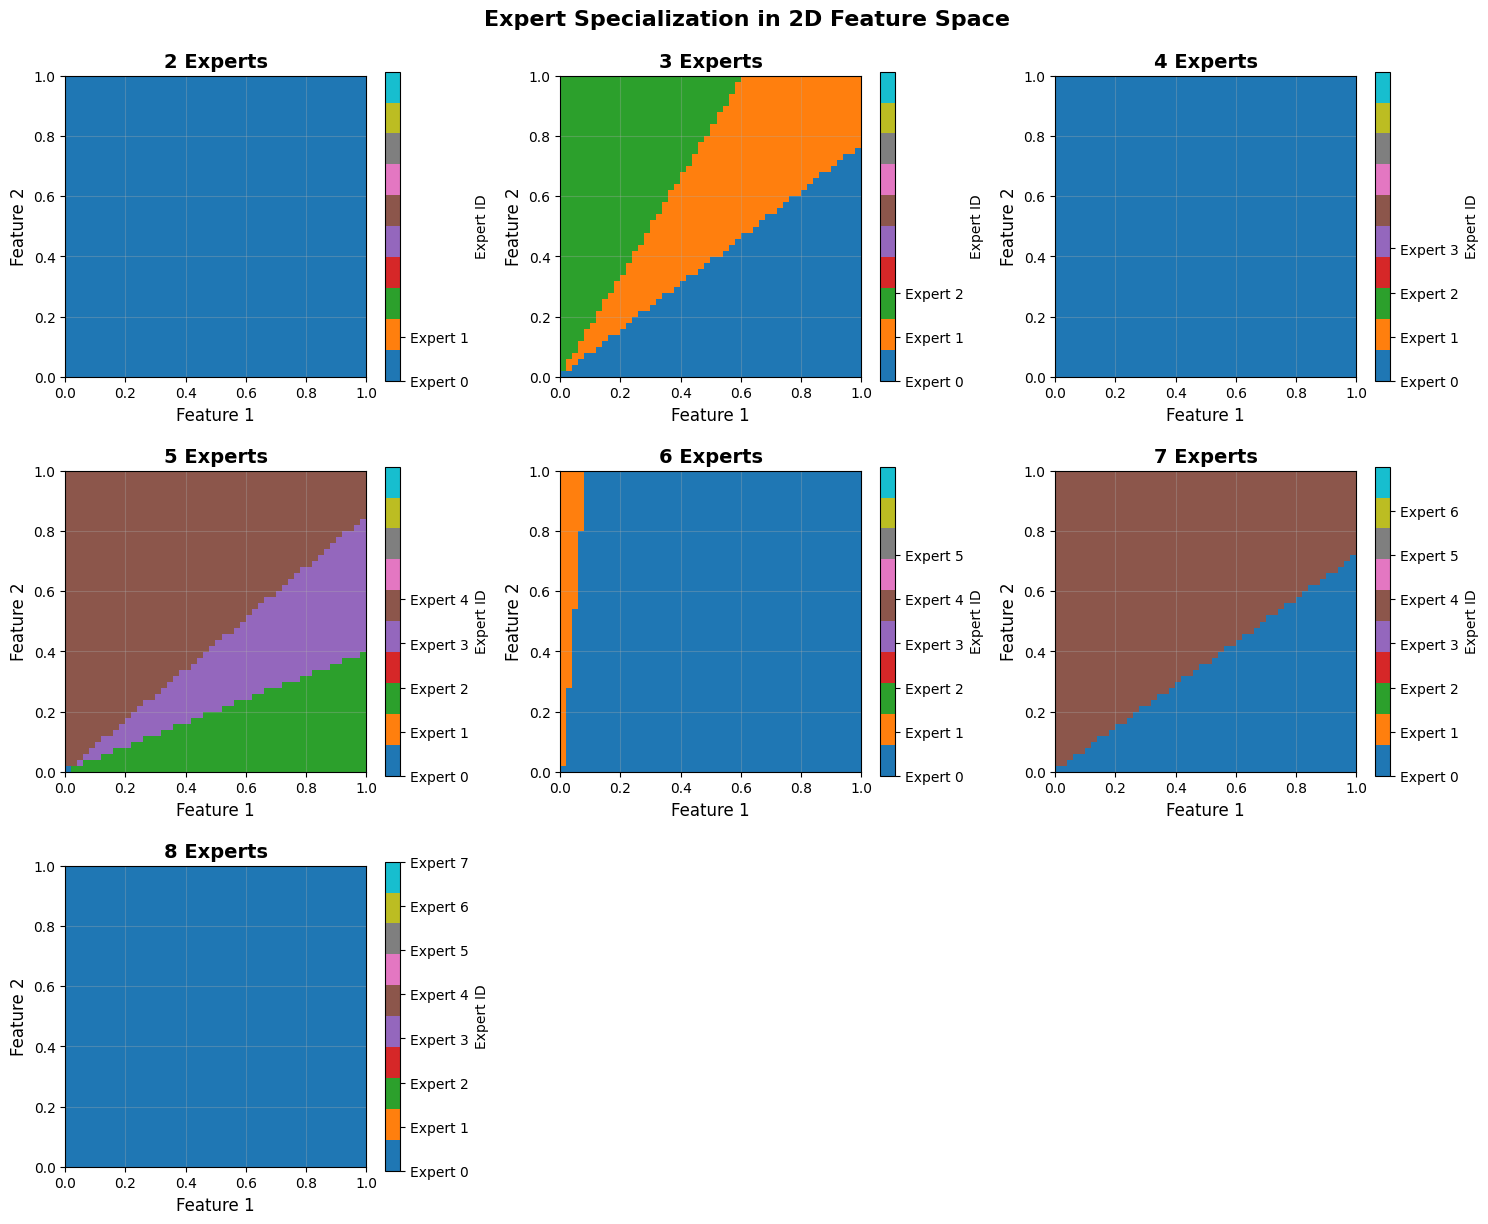

In [50]:
# Create the expert specialization visualization
fig = create_expert_specialization_plots(models_dict, resolution=50)

# Optional: Save the figure
fig.savefig('expert_specialization.png', dpi=300, bbox_inches='tight')


In [22]:
def analyze_expert_utilization(models_dict, resolution=100):
    """
    Analyze how evenly the feature space is divided among experts.
    """
    
    # Create a grid of feature combinations
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X, Y = np.meshgrid(x, y)
    feature_grid = np.stack([X.flatten(), Y.flatten()], axis=1)
    feature_tensor = torch.tensor(feature_grid, dtype=torch.float32)
    
    results = {}
    
    for num_experts, model in sorted(models_dict.items()):
        with torch.no_grad():
            # Compute gate scores
            gate_scores = torch.einsum("bf,ef->be", feature_tensor, model.gate)
            gate_probs = F.softmax(gate_scores, dim=-1)
            
            # Get the top expert for each point
            _, top_expert_indices = torch.topk(gate_probs, k=1, dim=-1)
            expert_assignments = top_expert_indices.squeeze(-1).numpy()
        
        # Calculate utilization statistics
        unique_experts, counts = np.unique(expert_assignments, return_counts=True)
        total_points = len(expert_assignments)
        
        utilization = np.zeros(num_experts)
        for expert_id, count in zip(unique_experts, counts):
            utilization[expert_id] = count / total_points
        
        results[num_experts] = {
            'utilization': utilization,
            'active_experts': len(unique_experts),
            'max_utilization': utilization.max(),
            'min_utilization': utilization.min(),
            'std_utilization': utilization.std(),
            'unused_experts': num_experts - len(unique_experts)
        }
        
        print(f"\\n{num_experts} Experts:")
        print(f"  Active experts: {len(unique_experts)}/{num_experts}")
        print(f"  Utilization per expert: {utilization}")
        print(f"  Max utilization: {utilization.max():.3f}")
        print(f"  Min utilization: {utilization.min():.3f}")
        print(f"  Std utilization: {utilization.std():.3f}")
        if len(unique_experts) < num_experts:
            unused = [i for i in range(num_experts) if i not in unique_experts]
            print(f"  Unused experts: {unused}")
    
    return results


In [51]:
# Analyze expert utilization
utilization_stats = analyze_expert_utilization(models_dict, resolution=50)

\n2 Experts:
  Active experts: 1/2
  Utilization per expert: [1. 0.]
  Max utilization: 1.000
  Min utilization: 0.000
  Std utilization: 0.500
  Unused experts: [1]
\n3 Experts:
  Active experts: 3/3
  Utilization per expert: [0.3868 0.3112 0.302 ]
  Max utilization: 0.387
  Min utilization: 0.302
  Std utilization: 0.038
\n4 Experts:
  Active experts: 1/4
  Utilization per expert: [1. 0. 0. 0.]
  Max utilization: 1.000
  Min utilization: 0.000
  Std utilization: 0.433
  Unused experts: [1, 2, 3]
\n5 Experts:
  Active experts: 4/5
  Utilization per expert: [4.000e-04 0.000e+00 2.028e-01 2.228e-01 5.740e-01]
  Max utilization: 0.574
  Min utilization: 0.000
  Std utilization: 0.210
  Unused experts: [1]
\n6 Experts:
  Active experts: 2/6
  Utilization per expert: [0.9528 0.0472 0.     0.     0.     0.    ]
  Max utilization: 0.953
  Min utilization: 0.000
  Std utilization: 0.352
  Unused experts: [2, 3, 4, 5]
\n7 Experts:
  Active experts: 2/7
  Utilization per expert: [0.3616 0.     

In [52]:
print(f"Each of the expert weights:")
for key, model in models_dict.items():
    print(f"Number of experts: {key}")
    print(f"Expert weights: {model.W_experts}")
    print(f"Gate matrix: {model.gate}")

Each of the expert weights:
Number of experts: 2
Expert weights: Parameter containing:
tensor([[[-0.9421],
         [-0.3520]],

        [[ 0.3565],
         [ 0.8614]]], requires_grad=True)
Gate matrix: Parameter containing:
tensor([[0., 0.],
        [0., 0.]], requires_grad=True)
Number of experts: 3
Expert weights: Parameter containing:
tensor([[[ 0.9255],
         [ 0.3508]],

        [[ 0.5664],
         [ 0.8159]],

        [[-0.1093],
         [-0.9549]]], requires_grad=True)
Gate matrix: Parameter containing:
tensor([[ 1.5619e-04, -1.7285e-04],
        [-5.3953e-05,  1.0046e-04],
        [-5.8193e-05,  1.0305e-04]], requires_grad=True)
Number of experts: 4
Expert weights: Parameter containing:
tensor([[[-0.6961],
         [-0.7173]],

        [[-0.3424],
         [ 0.1910]],

        [[-0.2182],
         [-1.0086]],

        [[ 0.6424],
         [-0.2022]]], requires_grad=True)
Gate matrix: Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0.,

In [58]:
classify_expert_weights_2d(models_dict[3].W_experts)

{'expert_0': {'hidden_dimensions': [{'classification': 'orthogonal_feature_0',
    'similarity': 0.9350925087928772,
    'weights': [0.9254990816116333, 0.35076773166656494],
    'pattern': [1.0, 0.0]}],
  'raw_weights': [[0.9254990816116333], [0.35076773166656494]]},
 'expert_1': {'hidden_dimensions': [{'classification': 'superposition_both_positive',
    'similarity': 0.9841011379562069,
    'weights': [0.5664456486701965, 0.8159357309341431],
    'pattern': [1.0, 1.0]}],
  'raw_weights': [[0.5664456486701965], [0.8159357309341431]]},
 'expert_2': {'hidden_dimensions': [{'classification': 'orthogonal_feature_1',
    'similarity': 0.9935163855552673,
    'weights': [-0.10926450788974762, -0.954852283000946],
    'pattern': [0.0, 1.0]}],
  'raw_weights': [[-0.10926450788974762], [-0.954852283000946]]}}

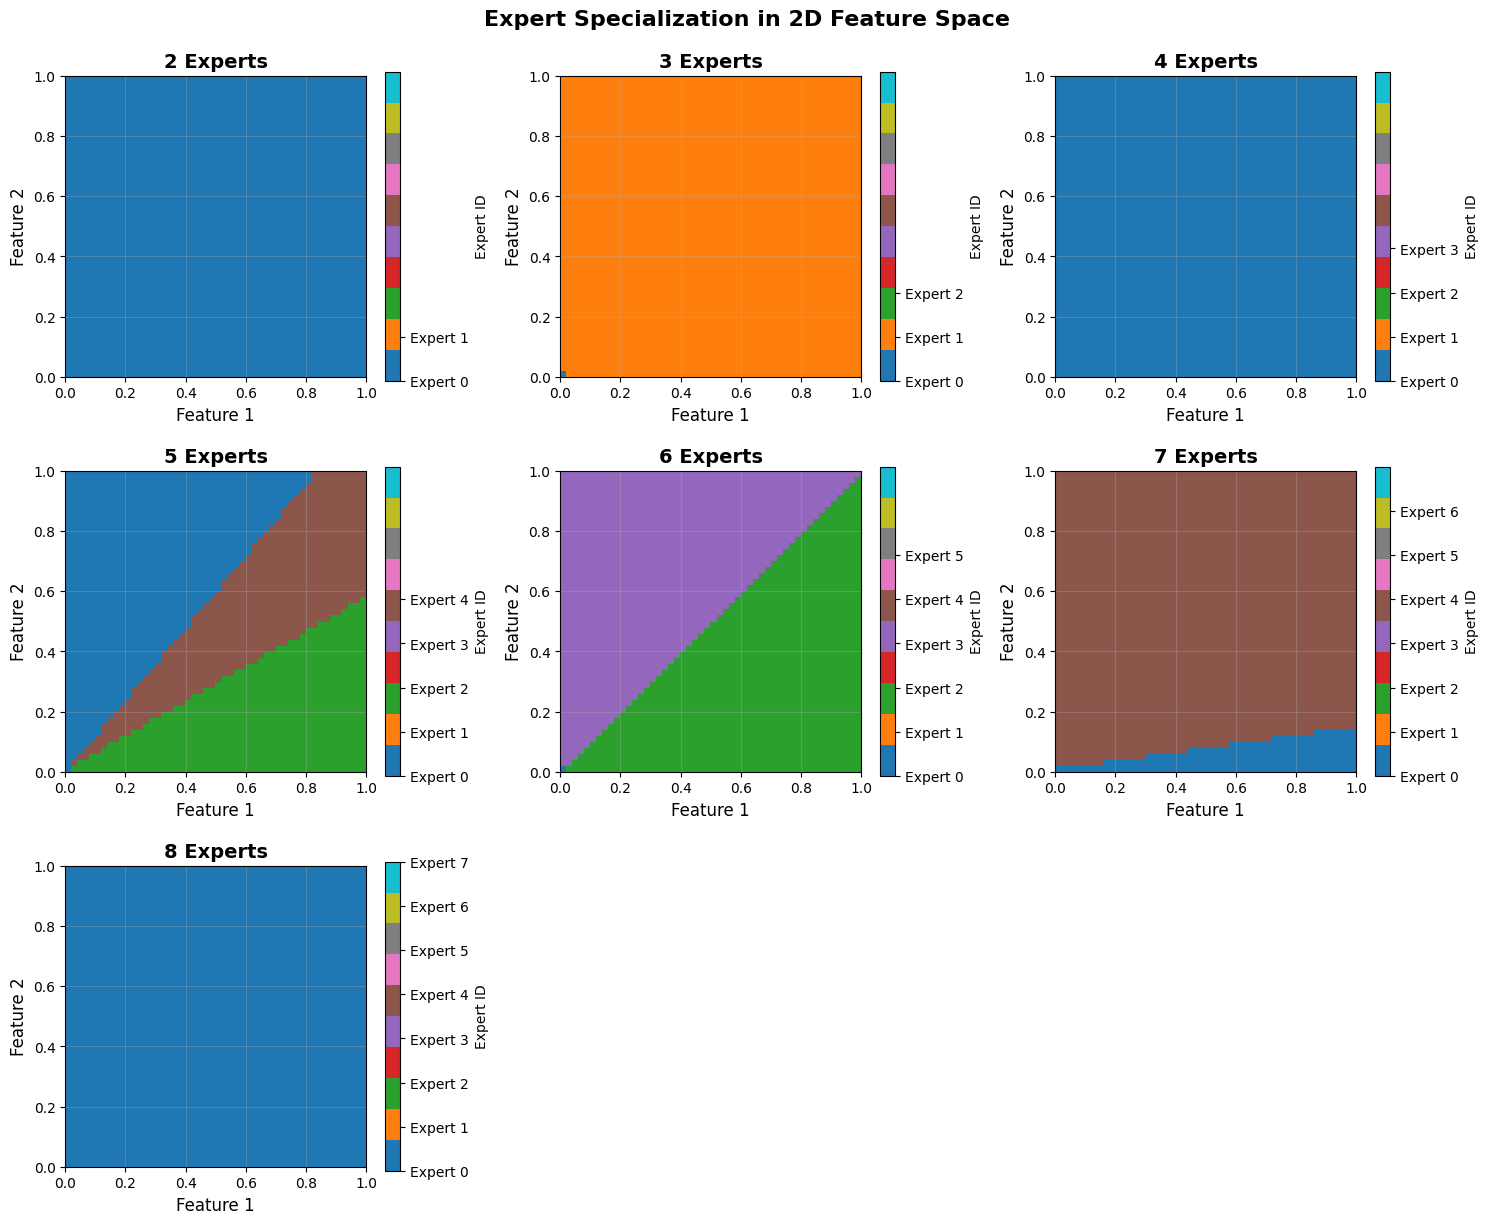

In [44]:
w_expert = torch.nn.Parameter(torch.tensor([[[-0.5050],
         [-0.8461]],

        [[-0.5799],
         [-0.4866]],

        [[ 0.9613],
         [ 0.2032]],

        [[-0.9279],
         [ 0.2787]],

        [[-0.6656],
         [-0.7333]]]))

gate_matrix = torch.nn.Parameter(torch.tensor([[-1.1900e-03,  1.6417e-03],
        [-5.7817e-05, -2.1986e-04],
        [ 1.5167e-03, -1.7153e-03],
        [-1.7807e-04,  6.3105e-04],
        [ 2.9567e-04,  3.9874e-04]]))

model = MoEModel(config, device='cpu', feature_probability=torch.tensor(1), importance=torch.tensor(1))
model.W_experts = w_expert
model.gate = gate_matrix

models_dict[5] = model
fig = create_expert_specialization_plots(models_dict, resolution=50)
